| **Chapter**                   | 7:  Temporal dynamics of epidemics                   |
| ----------------------------- |------------------------------------------------------|
| **Computational Note**        | 7.x: Discrete Lyapunov exponents to estimate chaos   |
| **Package prerequisites**     | [JiTCODE](https://jitcode.readthedocs.io/en/latest/) |


# Discrete Lyapunov exponents to estimate chaos

In [1]:
import numpy as np
from jitcode import jitcode_lyap, y, t
import symengine
from symengine import sin, pi
from matplotlib import pyplot as plt
import seaborn as sns
import random

from tqdm.notebook import tqdm

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p jitcode

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

jitcode: 1.6.0

symengine : 0.9.2
numpy     : 1.21.6
seaborn   : 0.11.2
matplotlib: 3.5.2



# Setting parameters

In [3]:
beta_0 = 1.3
gamma = 1/13
mu = 1/(40 * 365)

I_0 = 1e-3
S_0 = 1/15

In [4]:
S, I = dynvars = [y(i) for i in range(2)]

# Defining the model

## Defining the derivative function with reference to $\beta_1$

In [5]:
beta_1 = symengine.Symbol("beta_1")

time_dependent_sir = {
    S: mu - beta_0 * (1 + beta_1 * sin(2 * pi * t / 365)) * S * I - mu * S,
    I: beta_0 * (1 + beta_1 * sin(2 * pi * t / 365)) * S * I - mu * I - gamma * I
}

## Defining initial state and state array

In [6]:
initial_state = np.array([S_0, I_0])

In [7]:
resolution = 10000

In [8]:
times = np.linspace(0, resolution, resolution)

# Integrative solving of the ODE

In [9]:
ODE = jitcode_lyap(time_dependent_sir, control_pars=[beta_1], n_lyap=1)

In [10]:
ODE.set_integrator("dopri5")

Generating, compiling, and loading C code.
generated C code for f


In [11]:
ODE.set_initial_value(initial_state, time=0.0)

In [12]:
beta_1_range = np.linspace(0, 0.3, 10000)

In [13]:
bifurcation_map = np.zeros(shape=(10, 10000))

In [14]:
lyapunov_map = np.zeros(shape=(10000))

## Solving for the entire $\beta_1$ space with Lyapunov exponents

In [15]:
for b1idx, i in enumerate(tqdm(beta_1_range)):
    ODE.set_initial_value(initial_state, time=0.0)
    ODE.set_parameters(i)
    
    ys, lyaps = [], []

    for T in np.arange(0, 10000, 1):
        y, lyap, _ = ODE.integrate(T)
        if T > 3650:
            ys.append(y[1])
            lyaps.append(lyap)

    for idx, val in enumerate(ys[4000::365]):
        bifurcation_map[idx, b1idx] = val
    
    lyapunov_map[b1idx] = np.mean(lyaps)

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/jitcode/_jitcode.py:758: RuntimeWarning: invalid value encountered in true_divide
  lyaps = log(norms) / delta_t
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/jitcode/_jitcode.py:758: RuntimeWarning: divide by zero encountered in true_divide
  lyaps = log(norms) / delta_t


# Plotting results

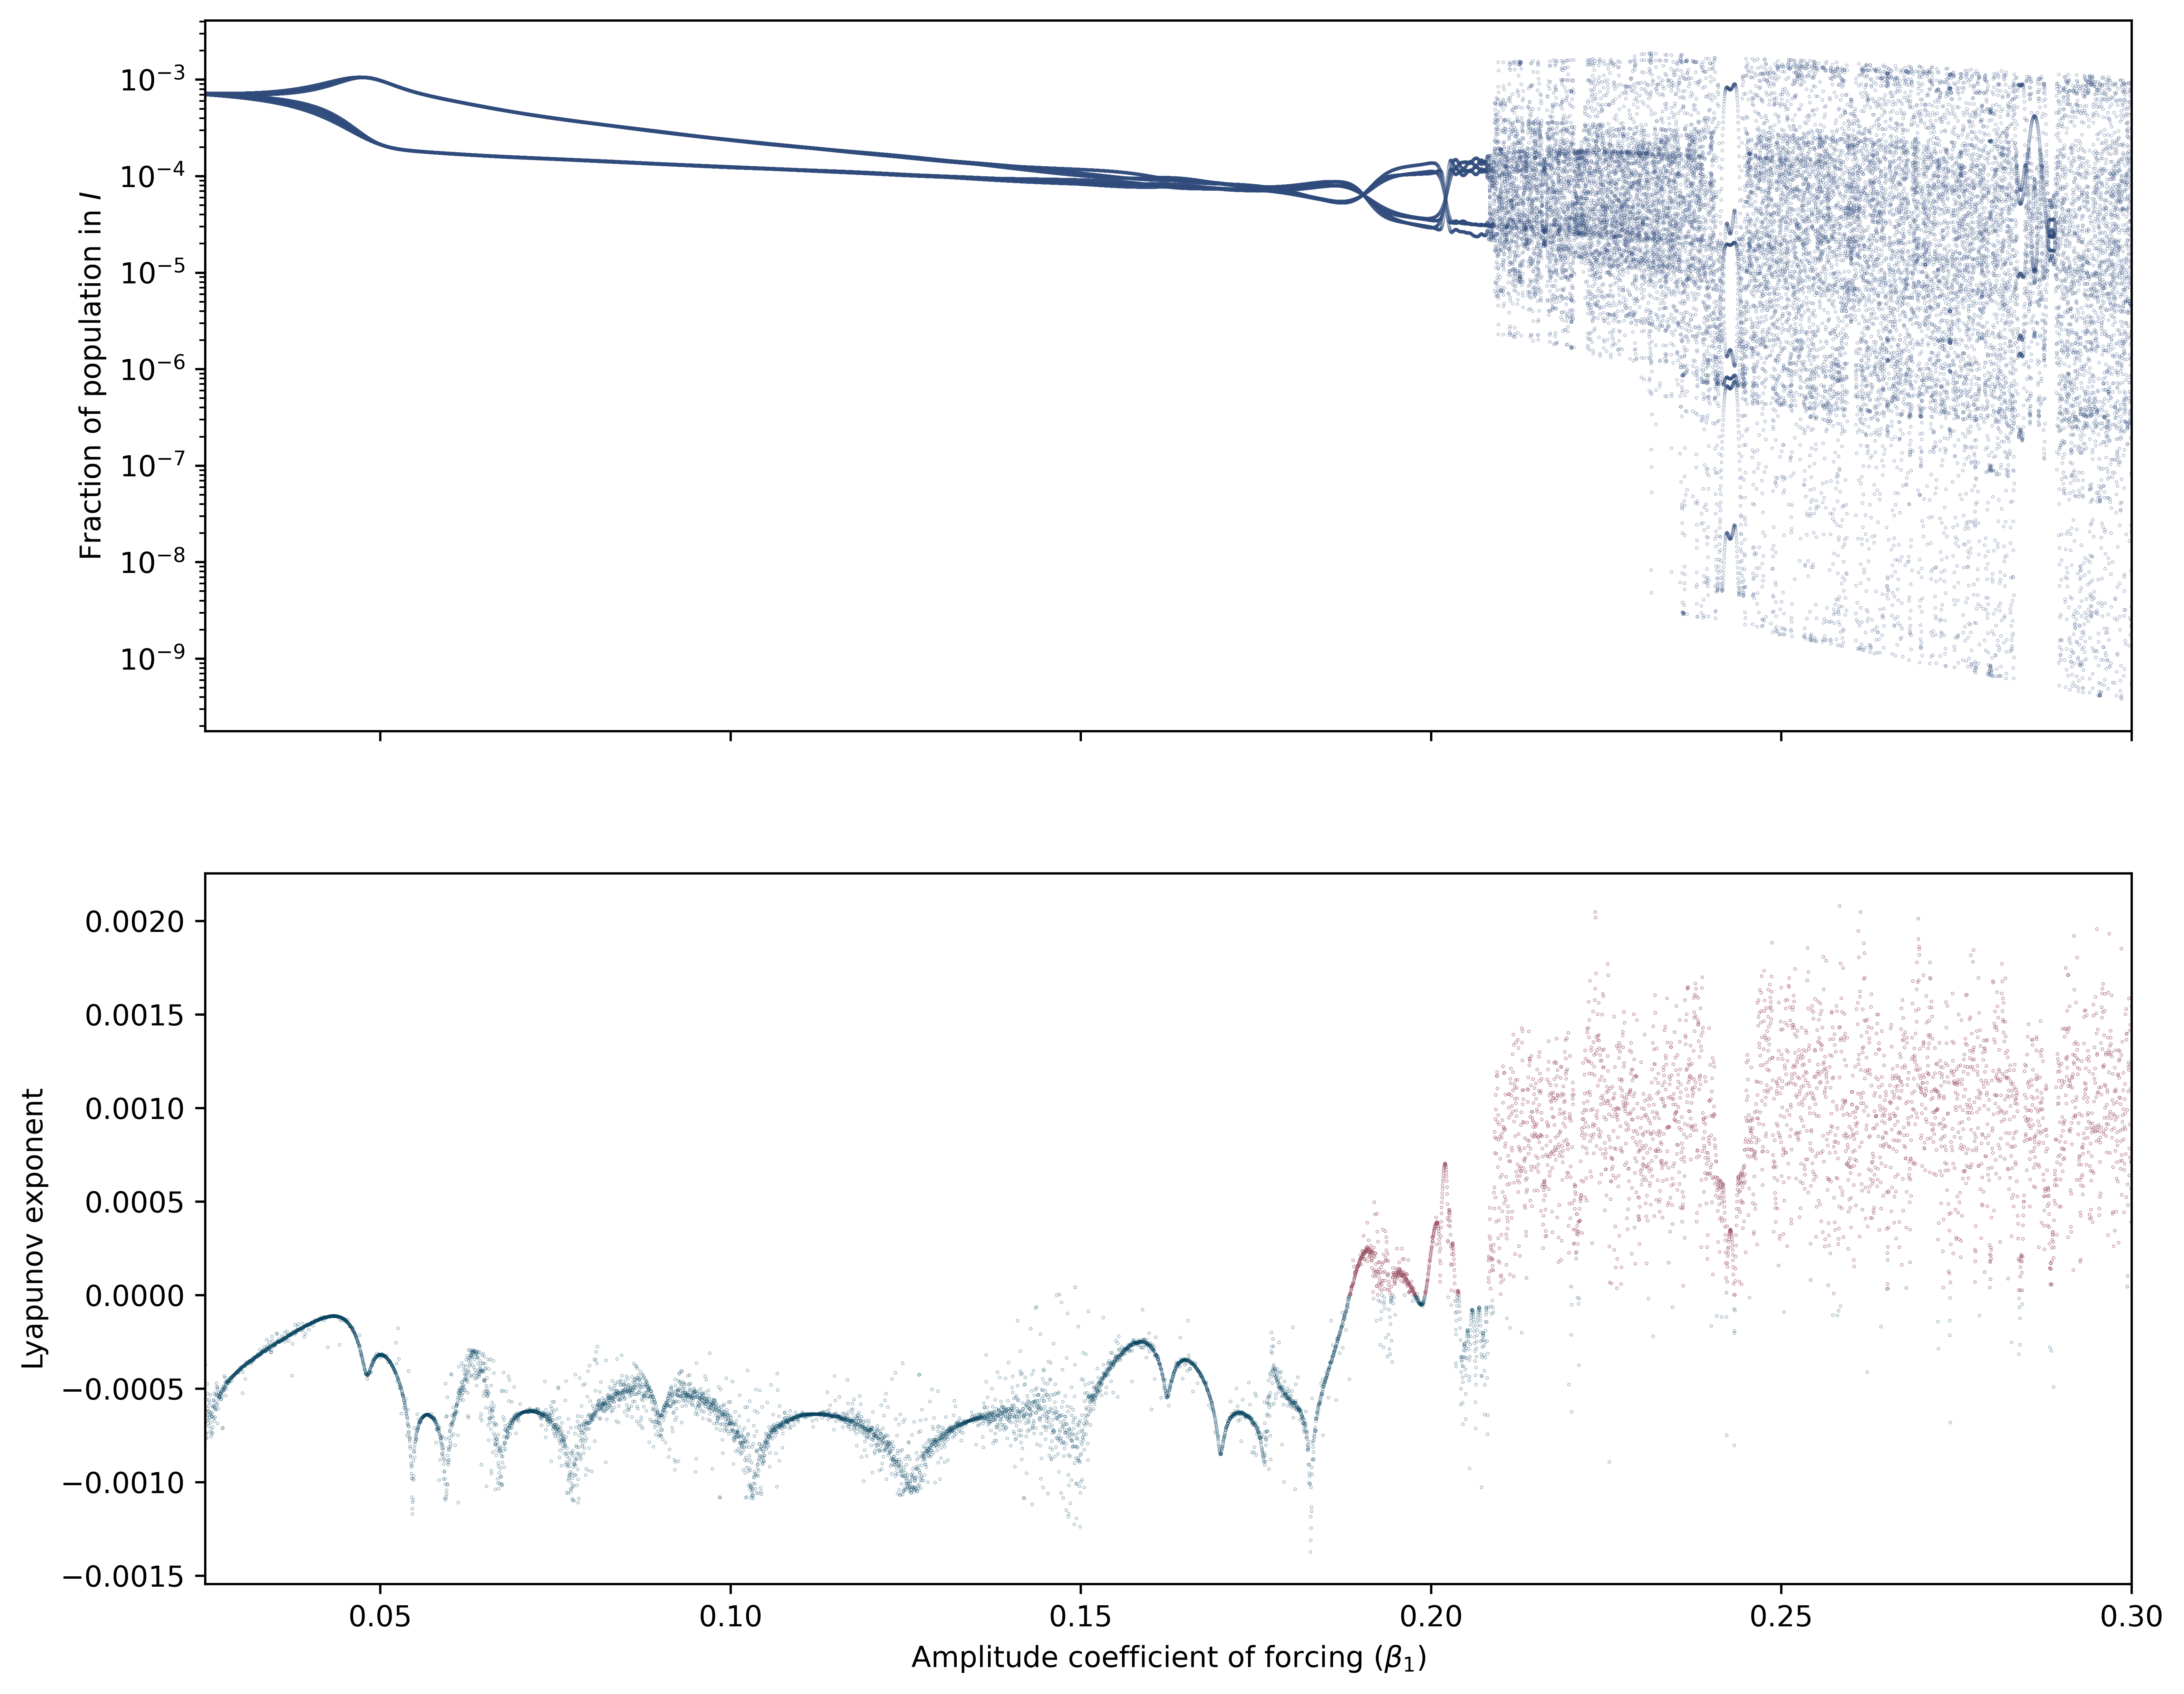

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, dpi=600)


axes[0].set_xlim((0.025, 0.3))
axes[0].set_yscale("log")

for i in range(10):
    axes[0].scatter(beta_1_range, bifurcation_map[i, :], marker=".", c=COLORS["S"], alpha=0.5, s=0.1)
    
for idx, point in enumerate(lyapunov_map):
    axes[1].scatter(beta_1_range[idx], point, marker=".", c=COLORS["D"], alpha=0.5, s=0.1)

    if point > 0:
        axes[1].scatter(beta_1_range[idx], point, marker=".", c=COLORS["I"], alpha=0.5, s=0.1)

axes[0].set_ylabel("Fraction of population in $I$")
axes[1].set_ylabel("Lyapunov exponent")
axes[1].set_xlabel("Amplitude coefficient of forcing ($\\beta_1$)")

plt.savefig("bifurcation_lyapunov.pdf")